In [1]:
import re

import pandas as pd
from utils import load_df_with_time_index
import matplotlib.pyplot as plt


In [20]:
query_calls = load_df_with_time_index("quick/perfwamd2_2025-08-21_13-30-00-Panel Title.csv")
query_calls  = query_calls.melt(var_name='meta', value_name='group_duration', ignore_index=False)

In [22]:
def extract_fields(meta):
    match = re.search(r'{__name__="([^"]+)", group="::([^"]+)", scenario="([^"]+)"}', meta)
    if match:
        return match.group(1), match.group(2), match.group(3)
    return None, None, None


In [23]:
query_calls[['count_name', 'group', 'scenario']] = query_calls['meta'].apply(lambda x: pd.Series(extract_fields(x)))

In [25]:
query_calls.drop(columns=['meta', 'count_name'], inplace=True)

In [34]:
total_time = query_calls.index.max() - query_calls.index.min()
total_time = total_time.total_seconds() * 1000
print(f'Total time: {total_time}')

Total time: 4170000.0


In [36]:
query_calls[query_calls['scenario'] == 'ARInvoiceTracker'].groupby('group').agg({'group_duration': 'mean'}).sort_values(by='group_duration', ascending=False).head(10)

,group_duration
group,
GLJrnDtlSvc_GetRows,8.740000
GetRows,8.460509
GetByID,2.910471


In [71]:
def grafana_rate(group):
    # Your custom aggregation logic here
    # Example: calculate per-second rate for each group
    count = group['group_duration'].astype(float)
    time_diff = group.index.to_series().diff().dt.total_seconds()
    count_diff = count.diff()
    rate = count_diff / time_diff
    return pd.Series(rate, index=group.index, name='rate_grafana')

# Apply per group and add result as a new column
# query_calls.groupby('group').apply(grafana_rate)
#query_calls.groupby('group').apply(grafana_rate, include_groups=False)
query_calls.groupby('group').apply(grafana_rate, include_groups=False).reset_index(level=0).groupby('group').agg({'rate_grafana': 'mean'}).sort_values(by='rate_grafana', ascending=False).head(10) * 1000 # Convert to milliseconds

,rate_grafana
group,
PartTracker_GetListAndOrderAllocationGetRows,6.872970
CustomerTracker_GetCashDtlsForCustomerActivity,0.490196
SOEntry10ShipTos_MasterUpdate_Detail_1,0.151177
PartTracker_GetRowsPerPlantKinetic,0.146520
SOEntry10ShipTos_MasterUpdate_OrderHed_2,0.120051
SalesOrderEntry_GetByID,0.097744
SOEntry10ShipTos_MasterUpdate_OrderRel_4,0.078144
CustomerTracker_GetRowsCustomerTrackerAndSort,0.072727
SOEntry10ShipTos_MasterUpdate_OrderRel_2,0.064436


In [80]:
query_calls[query_calls['scenario'] == 'ARInvoiceTracker'].groupby('group').apply(grafana_rate, include_groups=False).transpose().mean() * 1000

group
GLJrnDtlSvc_GetRows    0.024331
GetByID               -1.178182
GetRows                0.007299
dtype: float64

In [37]:
query_calls.groupby('scenario').agg({'group_duration': 'mean'}).sort_values(by='group_duration', ascending=False).head(10)

,group_duration
scenario,
CustomerTracker,9.701698
ARInvoiceTracker,6.699068
CopySalesOrder,5.118415
PartTracker,4.450849
SalesOrderTracker,3.842532
GLJournalTracker,3.689052
QuoteEntry,2.577587
SOEntry10ShipTos,2.537744
SalesOrderEntry,2.523062


In [3]:
# Assume df is your original DataFrame with time as index
df = query_calls.copy()
# Reset index and rename the first column to 'TIME'
df_reset = df.reset_index()
df_reset.rename(columns={df_reset.columns[0]: 'TIME'}, inplace=True)

# Melt the DataFrame to long format
df_long = df_reset.melt(id_vars=['TIME'], var_name='meta', value_name='count')

# Extract fields from the column names
def extract_fields(meta):
    match = re.search(r'{__name__="([^"]+)", group="::([^"]+)", scenario="([^"]+)"}', meta)
    if match:
        return match.group(1), match.group(2), match.group(3)
    return None, None, None

df_long[['count_name', 'group', 'scenario']] = df_long['meta'].apply(lambda x: pd.Series(extract_fields(x)))

# Final DataFrame
result_df = df_long[['TIME', 'count', 'group', 'scenario']]


In [7]:
result_df[result_df['scenario'] == 'ARInvoiceTracker'].groupby('group').agg({'count': 'mean'}).sort_values(by='count', ascending=False).head(10)

,count
group,
GLJrnDtlSvc_GetRows,8.740000
GetRows,8.460509
GetByID,2.910471


In [9]:
# Calculate time difference in seconds
result_df['time_diff'] = result_df['TIME'].diff().dt.total_seconds()

# Calculate count difference
result_df['count_diff'] = result_df['count'].diff()

# Calculate rate (count change per second)
result_df['rate'] = result_df['count_diff'] / result_df['time_diff']

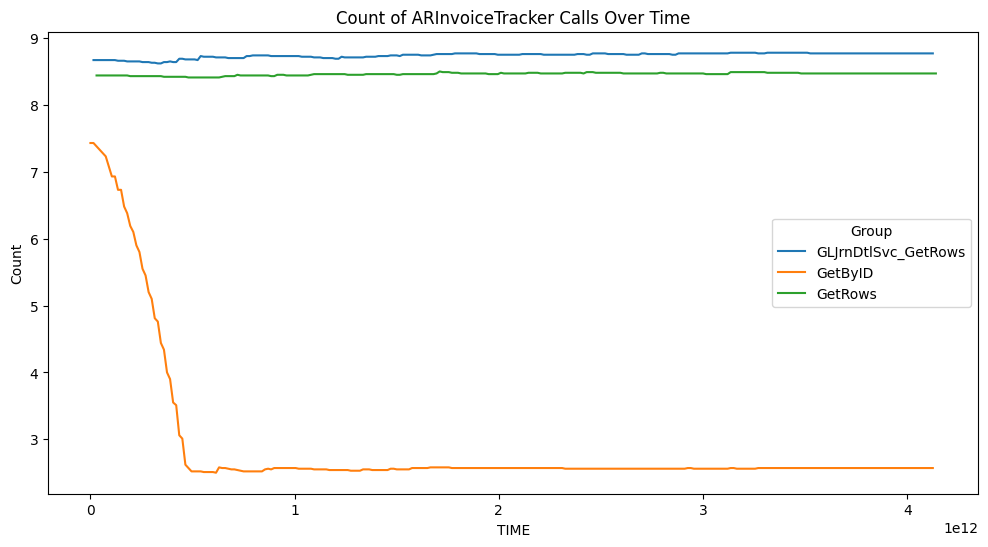

In [16]:
# Filter for the scenario
df_plot = result_df[result_df['scenario'] == 'ARInvoiceTracker']

plt.figure(figsize=(12, 6))
for group_name, group_data in df_plot.groupby('group'):
    plt.plot(group_data['TIME'], group_data['count'], label=group_name)

plt.title('Count of ARInvoiceTracker Calls Over Time')
plt.xlabel('TIME')
plt.ylabel('Count')
plt.legend(title='Group')
plt.show()

In [17]:
#result_df[result_df['scenario'] == 'ARInvoiceTracker'].groupby('group').plot(x='TIME', y='count', kind='line', figsize=(12, 6), title='count of ARInvoiceTracker Calls Over Time')

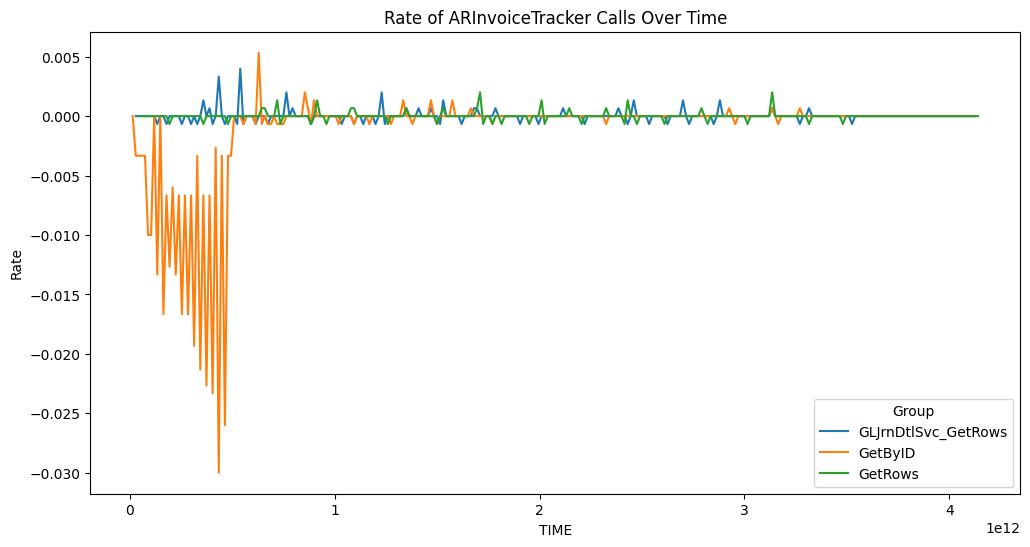

In [18]:
# result_df[result_df['scenario'] == 'ARInvoiceTracker'].groupby('group').plot(x='TIME', y='rate', kind='line', figsize=(12, 6), title='Rate of ARInvoiceTracker Calls Over Time')

df_plot = result_df[result_df['scenario'] == 'ARInvoiceTracker']

plt.figure(figsize=(12, 6))
for group_name, group_data in df_plot.groupby('group'):
    plt.plot(group_data['TIME'], group_data['rate'], label=group_name)

plt.title('Rate of ARInvoiceTracker Calls Over Time')
plt.xlabel('TIME')
plt.ylabel('Rate')
plt.legend(title='Group')
plt.show()

In [21]:
result_df[result_df['scenario'] == 'ARInvoiceTracker'].groupby('group').agg({'rate': 'mean'}).sort_values(by='rate', ascending=False).head(10) * 1000 # Convert to milliseconds

,rate
group,
GLJrnDtlSvc_GetRows,0.024331
GetRows,0.007299
GetByID,-1.178182


In [ ]:
result_df[result_df['scenario'] == 'ARInvoiceTracker'].groupby('group').agg({'count': 'mean'}).sort_values(by='count', ascending=False).head(10)

In [7]:
#result_df = result_df.set_index('TIME')
x = 60  # window size in seconds

In [9]:
# Ensure TIME is sorted for each group
result_df = result_df.sort_values(['group', 'TIME'])

def rolling_rate(group):
    count_diff = group['count'].diff()
    time_diff = group.index.to_series().diff().dt.total_seconds()
    rate = count_diff / time_diff
    return rate.rolling(f'{x}s').mean()

result_df['rate_window'] = (result_df.groupby('group').apply(rolling_rate)

_IncompleteInputError: incomplete input (741164883.py, line 10)

In [14]:


# Calculate rolling rate for each group
def rolling_rate(group):
    # Rolling count difference over x seconds
    count_diff = group['count'].diff()
    time_diff = group.index.to_series().diff().dt.total_seconds()
    rate = count_diff / time_diff
    # Rolling mean rate over x seconds
    return rate.rolling(f'{x}s').mean()

result_df['rate_window'] = result_df.groupby('group', group_keys=False).apply(rolling_rate)

ValueError: index values must be monotonic